In [1]:
import scipy
import os
import warnings
import numpy as np
from model import DGN
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torch.nn
import contextlib
import sys


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif', 'Arial', 'Liberation Serif']

#### 1. inspect

#### 2. data preprocessing

In [2]:
def normalize_matrix(connectivity_matrix):
    np.fill_diagonal(connectivity_matrix, 0)
    connectivity_matrix[np.logical_or(np.isinf(connectivity_matrix), np.isnan(connectivity_matrix))] = 0
    connectivity_matrix = connectivity_matrix.astype(float)
    
    return connectivity_matrix

In [3]:
import scipy.io
import numpy as np

connectivity_matrices_asd = []

for i in range(1, 155):
    mat = scipy.io.loadmat(f'data_nc_asd_R/data_nc_asd_R/ASD_RH/RHASDSub{i}.mat')
    connectivity_matrix = mat['views'][:, :, :]
    connectivity_matrix = [normalize_matrix(mat) for mat in connectivity_matrix]
    connectivity_matrices_asd.append(connectivity_matrix)

connectivity_matrices_asd = np.stack(connectivity_matrices_asd)

connectivity_matrices_control = []

for i in range(1, 186):
    mat = scipy.io.loadmat(f'data_nc_asd_R/data_nc_asd_R/NC_RH/RHNCSub{i}.mat')
    connectivity_matrix = mat['views'][:, :, :]
    connectivity_matrix = [normalize_matrix(mat) for mat in connectivity_matrix]
    connectivity_matrices_control.append(connectivity_matrix)

connectivity_matrices_control = np.stack(connectivity_matrices_control)


In [4]:
warnings.filterwarnings("ignore", category=UserWarning)

#### 3. train DGN for ASD

In [5]:
Dataset = "E" 

#Number of simulated subjects (overwriten if Dataset = "E") 
N_Subjects = 154

#Number of nodes for simulated brain networks (overwriten if Dataset = "E") 
N_Nodes = 35

#Number of brain views (overwriten if Dataset = "E")
N_views = 6

#Number of training epochs
N_max_epochs = 500

#Apply early stopping True/False
early_stop =  True

#Random subset size for SNL function  
random_sample_size = 10

#Number of cross validation folds
n_folds = 5

#Learning Rate for Adam optimizer
lr = 0.001

#Name of the model
model_name = "THREE_LOSSES_229"

#dimension of embeddings output by the first GDL layer (for each ROI)
CONV1 = 8
#dimension of embeddings output by the second GDL layer (for each ROI)
CONV2 = 8
#dimension of embeddings output by the third GDL layer (for each ROI)
CONV3 = 8

lambda1 = 200
lambda2 = 50
patience = 3

#----------------------------------------------------------------------------#
#----------------------------------------------------------------------------#
#                 Below is not to be modified manually                       #
#----------------------------------------------------------------------------#
#----------------------------------------------------------------------------#

import helper

if Dataset.lower() not in ["e", "E", "s", "S"]:
    raise ValueError("Dataset options are E or S.")
    
if (Dataset.lower() == "e"):
    X = connectivity_matrices_asd
    N_Subjects = X.shape[0]
    N_Nodes = X.shape[1]
    N_views = X.shape[3]
else:
    X = helper.create_better_simulated(N_Subjects, N_Nodes) if N_views == 4 else helper.simulate_dataset(N_Subjects, N_Nodes, N_views)


CONFIG = {
        "X": X,
        "N_ROIs":  X.shape[1],
        "N_views":  X.shape[3],
        "N_max_epochs": N_max_epochs,
        "n_folds": n_folds,
        "random_sample_size": random_sample_size,
        "early_stop": early_stop,
        "model_name": model_name
    }

MODEL_PARAMS = {
        "N_ROIs": N_Nodes,
        "learning_rate" : lr,
        "n_attr": X.shape[3],
        "Linear1" : {"in": N_views, "out": CONV1},
        "conv1": {"in" : 1, "out": CONV1},
        
        "Linear2" : {"in": N_views, "out": CONV1*CONV2},
        "conv2": {"in" : CONV1, "out": CONV2},
        
        "Linear3" : {"in": N_views, "out": CONV2*CONV3},
        "conv3": {"in" : CONV2, "out": CONV3},
        "lambda1" : lambda1,
        "lambda2" : lambda2,
        "patience" : patience,
    }

********* FOLD 0 *********
Epoch: 0  |  cbt loss : 26.92 | reservoir loss : 0.0937 | bio loss : 0.59640 | total loss: 75.48 | median cbt mc 10.01 | Time Elapsed: 35.46 | 
Epoch: 10  |  cbt loss : 18.48 | reservoir loss : 0.0928 | bio loss : 0.57032 | total loss: 65.56 | median cbt mc 10.21 | Time Elapsed: 156.66 | 
Epoch: 20  |  cbt loss : 15.49 | reservoir loss : 0.0926 | bio loss : 0.58194 | total loss: 63.10 | median cbt mc 10.27 | Time Elapsed: 108.04 | 
Epoch: 30  |  cbt loss : 13.50 | reservoir loss : 0.0925 | bio loss : 0.58874 | total loss: 61.44 | median cbt mc 10.13 | Time Elapsed: 36.05 | 
Epoch: 40  |  cbt loss : 12.60 | reservoir loss : 0.0925 | bio loss : 0.58971 | total loss: 60.58 | median cbt mc 10.26 | Time Elapsed: 36.26 | 
Epoch: 50  |  cbt loss : 12.11 | reservoir loss : 0.0925 | bio loss : 0.57220 | total loss: 59.21 | median cbt mc 10.27 | Time Elapsed: 110.29 | 
Epoch: 60  |  cbt loss : 11.75 | reservoir loss : 0.0925 | bio loss : 0.57588 | total loss: 59.03 | m

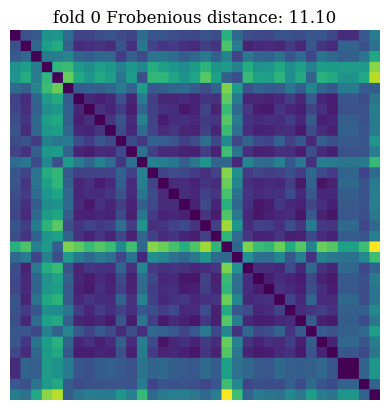

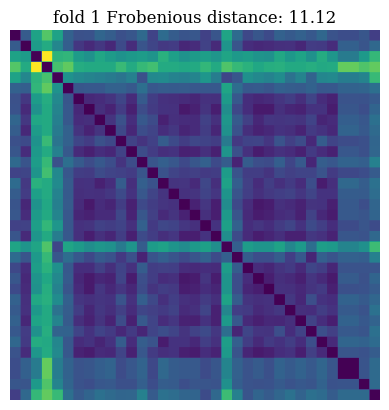

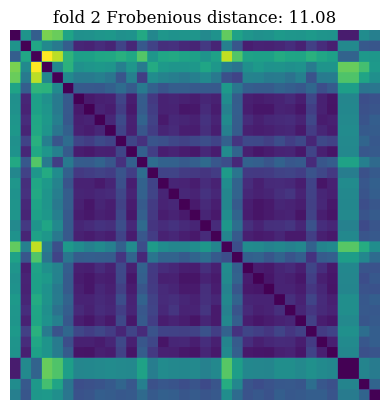

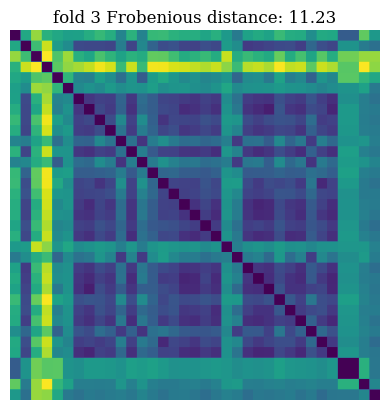

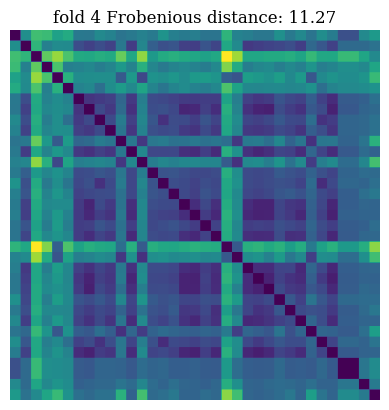

In [6]:
# lambda2 = 50
np.random.seed(35813)
torch.manual_seed(35813)
models = DGN.train_model(
                CONFIG["X"],
                model_params=MODEL_PARAMS,
                n_max_epochs=CONFIG["N_max_epochs"],
                n_folds=CONFIG["n_folds"],
                random_sample_size=CONFIG["random_sample_size"],
                early_stop=CONFIG["early_stop"],
                model_name=CONFIG["model_name"])

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def Frob_plot_multiview3(Frob_dist_DGN, Frob_dist_RC_integrated, Frob_dist_Third, up, low, legend=False):
    mean_DGN = np.mean(Frob_dist_DGN)
    std_DGN = np.std(Frob_dist_DGN, ddof=1)
    
    mean_RC_integrated = np.mean(Frob_dist_RC_integrated)
    std_RC_integrated = np.std(Frob_dist_RC_integrated, ddof=1)
    
    mean_Third = np.mean(Frob_dist_Third)
    std_Third = np.std(Frob_dist_Third, ddof=1)

    data = {
        "Model": ["CBT_Loss_only"]*6 + ["RC_integrated"]*6 + ["RC_integrated_asd_with_bio"]*6,
        "Frobenius Distance": np.concatenate([Frob_dist_DGN, [mean_DGN], Frob_dist_RC_integrated, [mean_RC_integrated], Frob_dist_Third, [mean_Third]]),
        "Fold": ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Mean']*3
    }

    df = pd.DataFrame(data)

    # Plotting
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=df, x="Fold", y="Frobenius Distance", hue="Model")

    x_ticks = ax.get_xticks()
    hues = df["Model"].unique()
    n_hues = len(hues)
    bar_width = ax.patches[0].get_width()
    means = [mean_DGN, mean_RC_integrated, mean_Third]
    stds = [std_DGN, std_RC_integrated, std_Third]
    
    for i, hue in enumerate(hues):
        mean_pos = x_ticks[-1] + i * bar_width - bar_width * (n_hues - 1) / 2
        ax.errorbar(mean_pos, means[i], yerr=stds[i], fmt='none', ecolor='black', capsize=5, capthick=2)

    plt.ylim(up, low)  # Set the y-axis scale
    plt.tight_layout()
    plt.show()

11.116 11.14 11.16
0.09687104830649895 0.02607680962081072 0.07563068160475622


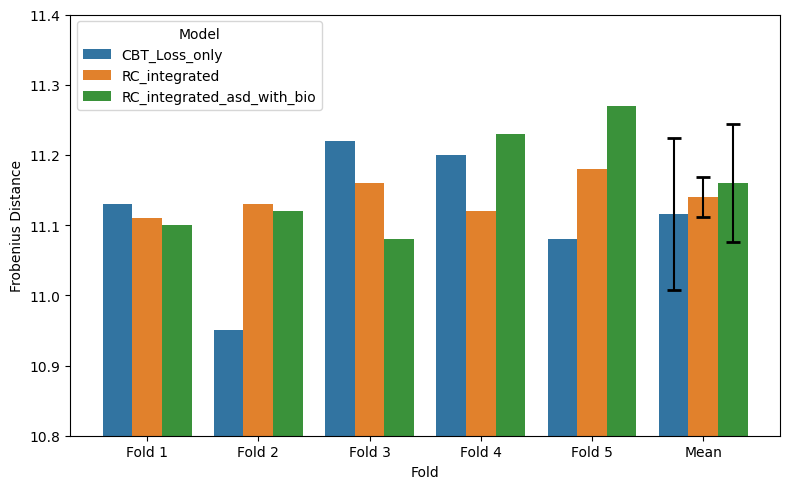

In [12]:
# centerness

three_losses = [11.10, 11.12, 11.08, 11.23, 11.27]
two_losses = [11.11, 11.13, 11.16, 11.12, 11.18]
one_loss = [11.13, 10.95, 11.22, 11.20, 11.08]

print(np.average(one_loss), np.average(two_losses), np.average(three_losses))
print(np.std(one_loss), np.std(two_losses), np.std(three_losses))

Frob_plot_multiview3(one_loss, two_losses, three_losses, 10.8, 11.4)


0.5906327091032507 0.5905480790247021 0.5886130642486165
0.01094403097212983 0.007717665468716252 0.02000361981465693


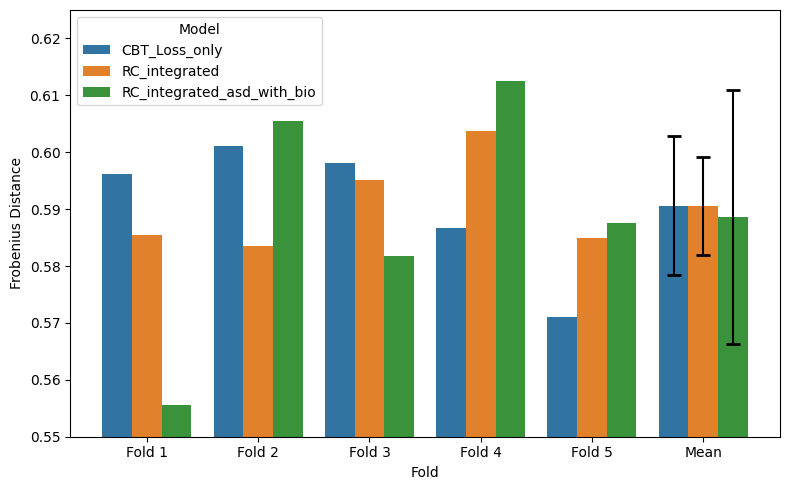

In [10]:
# bio mse
three_losses = [0.555595553470463,
0.6055401079744079,
0.5817120573719722,
0.6126011062154152,
0.5876164962108243]
two_losses = [0.5854004587121177,
0.5836079564195217,
0.5950780021020522,
0.6036561899107162,
0.5849977879791031]
one_loss = [0.5961961448339871,
0.6011601118589467,
0.598093671027123,
0.5867330846541627,
0.5709805331420341]

print(np.average(one_loss), np.average(two_losses), np.average(three_losses))
print(np.std(one_loss), np.std(two_losses), np.std(three_losses))
Frob_plot_multiview3(one_loss, two_losses, three_losses, 0.55, 0.625)


10.41552095317708 10.425456989530918 10.426476939986212
0.023422097233193658 0.010389377225712463 0.010311055514357806


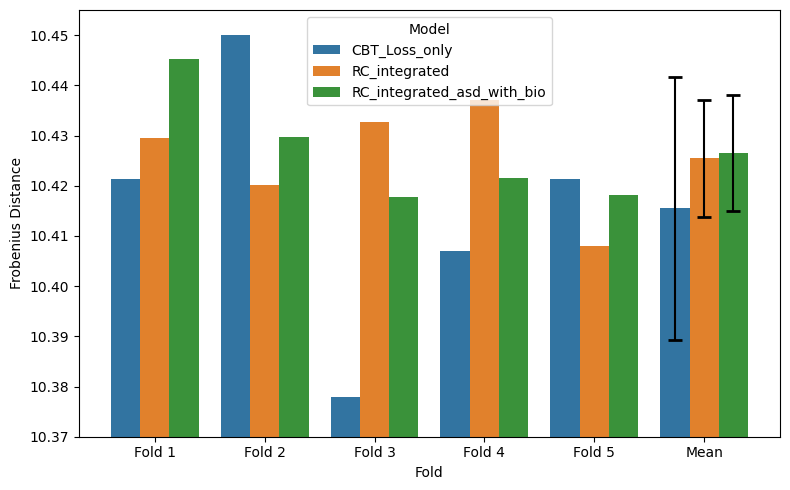

In [11]:
# memory capacity

one = [10.421248701634898,
10.450110346271599,
10.377989673618783,
10.40701245761515,
10.421243586744968]
two = [10.429516859080966,
10.42013834161465,
10.432656599881133,
10.437071567672346,
10.407901579405493]
three = [10.445247788819199,
10.429642443288751,
10.417843316872371,
10.421586740465877,
10.418064410484861,
]


print(np.average(one), np.average(two), np.average(three))
print(np.std(one), np.std(two), np.std(three))

Frob_plot_multiview3(one, two, three, 10.37, 10.455)
